In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import math
import os, shutil

##**Data gathering and preprocessing**

In [ ]:
DIR = "Dataset"
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="training", seed=42, batch_size=32, smart_resize=True, image_size=(256, 256))
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="validation", seed=42, batch_size=32, smart_resize=True, image_size=(256, 256))

classes = train_dataset.class_names
numClasses = len(train_dataset.class_names)
print(classes)

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 23472 files belonging to 5 classes.
Using 21125 files for training.
Found 23472 files belonging to 5 classes.
Using 2347 files for validation.
['Bacterial Pneumonia', 'COVID', 'Normal', 'Tuberculosis', 'Viral Pneumonia']


##<b>Data augmentation</b>

In [ ]:
data_augmentation = tf.keras.Sequential([
  #tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

##<b>Model Training</b>

In [ ]:
baseModel = tf.keras.applications.MobileNetV3Small(input_shape=(256, 256,3), weights='imagenet', include_top=False, classes=numClasses)
last_output = baseModel.layers[-1].output
x = tf.keras.layers.Dropout(0.5) (last_output)
x = tf.keras.layers.GlobalMaxPooling2D() (last_output)
x = tf.keras.layers.Dense(256, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.02), activity_regularizer=tf.keras.regularizers.l2(0.02),  kernel_initializer='he_normal')(x)
x = tf.keras.layers.BatchNormalization() (x)
x = tf.keras.layers.Dropout(0.45) (x)
x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

model = tf.keras.Model(inputs=baseModel.input, outputs=x)

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
epochs = 40
timeDecay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * 1 / (1 + 10 * epoch))
stepDecay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.1 * 0.1**math.floor(epoch / 6))
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, callbacks=[stepDecay])

6709248/6698480 [==============================] - 0s 0us/step
Epoch 1/40
661/661 [==============================] - 156s 212ms/step - loss: 2.4995 - accuracy: 0.8595 - val_loss: 1.6926 - val_accuracy: 0.6042 - lr: 0.1000
Epoch 2/40
661/661 [==============================] - 140s 210ms/step - loss: 0.3984 - accuracy: 0.9100 - val_loss: 0.5515 - val_accuracy: 0.8470 - lr: 0.1000
Epoch 3/40
661/661 [==============================] - 140s 209ms/step - loss: 0.3154 - accuracy: 0.9195 - val_loss: 5.9985 - val_accuracy: 0.4529 - lr: 0.1000
Epoch 4/40
661/661 [==============================] - 139s 208ms/step - loss: 0.3318 - accuracy: 0.9142 - val_loss: 0.4397 - val_accuracy: 0.8730 - lr: 0.1000
Epoch 5/40
661/661 [==============================] - 138s 207ms/step - loss: 0.3398 - accuracy: 0.9076 - val_loss: 0.7702 - val_accuracy: 0.7870 - lr: 0.1000
Epoch 6/40
661/661 [==============================] - 137s 206ms/step - loss: 0.3404 - accuracy: 0.9013 - val_loss: 0.3113 - val_accuracy: 0.9

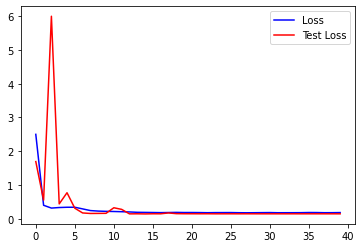

In [ ]:
plt.plot(range(0, epochs), history.history["loss"], color="b", label="Loss")
plt.plot(range(0, epochs), history.history["val_loss"], color="r", label="Test Loss")
plt.legend()
plt.show()

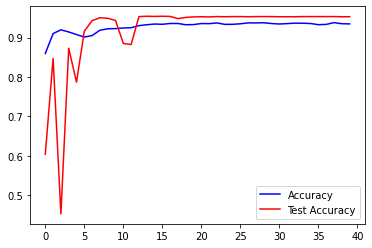

In [ ]:
plt.plot(range(0, epochs), history.history["accuracy"], color="b", label="Accuracy")
plt.plot(range(0, epochs), history.history["val_accuracy"], color="r", label="Test Accuracy")
plt.legend()
plt.show()

<b>Model Architecture and Management</b>

In [ ]:
model = tf.keras.models.load_model("../covid-classification-ml/XrayClassificationModel.h5")

In [ ]:
model.summary()

In [ ]:
model.save("model.h5")

##<b>Evaluation</b>

**One Image Prediction**

[5.9565809e-02 9.9642868e+01 4.8708733e-02 1.8394795e-01 6.4900428e-02] 
 ['Bacterial Pneumonia', 'COVID', 'Normal', 'Tuberculosis', 'Viral Pneumonia']
Prediction:  COVID 99.64286684989929%


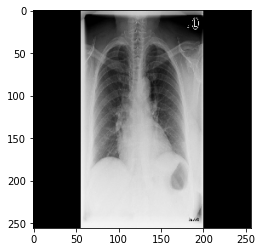

In [ ]:
path = "../Dataset/COVID/a9e081.png"

img = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)

plt.imshow(img)
print(predictions[0]*100, "\n", classes)
print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")

**Model Evaluation**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


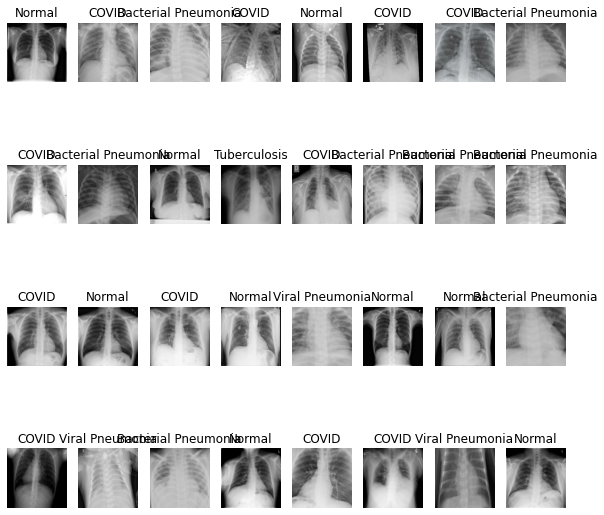

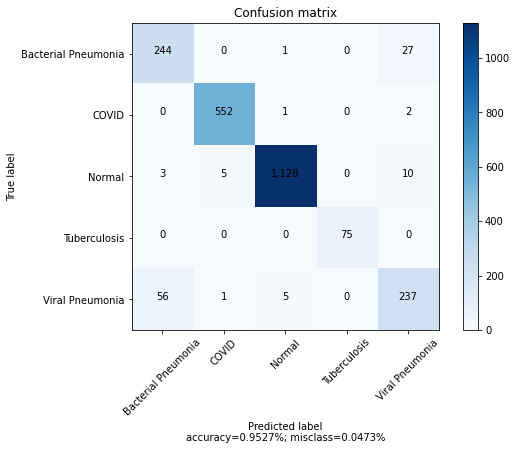

In [ ]:
def plot_confusion_matrix(cm, target_names, cmap=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}%; misclass={:0.4f}%'.format(accuracy, misclass))
    plt.show()

plt.figure(figsize=(10, 10))
true = []
predictions = []

for images, labels in test_dataset.take(1900):
  pred = model.predict(images)
  for i in range(32):
    try:
      ax = plt.subplot(4, 8, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      #print(classes[np.argmax(pred[i])], 100 * np.max(pred[i]), "real = " + str(classes[labels[i]]))

      true.append(labels[i])
      predictions.append(np.argmax(pred[i]))

      plt.title(classes[labels[i]])
      plt.axis("off")
    except:
      print()

plot_confusion_matrix(tf.math.confusion_matrix(true, predictions), classes)

In [ ]:
path = "../covid-classification-ml/Covid19_Dataset"
for i in os.listdir(path):
  folderPath = os.path.join(path, i)
  for j in os.listdir(folderPath)[:]:
    fullPath = os.path.join(folderPath, j)
    print(i, classes.index(i))

**Filter visualization**

In [ ]:
img_path='Dataset/COVID/a9e081.png' 

successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))# Convert ht image to Array of dimension (150,150,3)
x   = tf.keras.preprocessing.image.img_to_array(img)                           
x   = x.reshape((1,) + x.shape)# Rescale by 1/255
x /= 255.0

successive_feature_maps = visualization_model.predict(x)
layer_names = [layer.name for layer in model.layers]

for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:       
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    display_grid = np.zeros((size, size * n_features))
    
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x# Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='winter' )

<b>Advanced Activation Visualization </b>

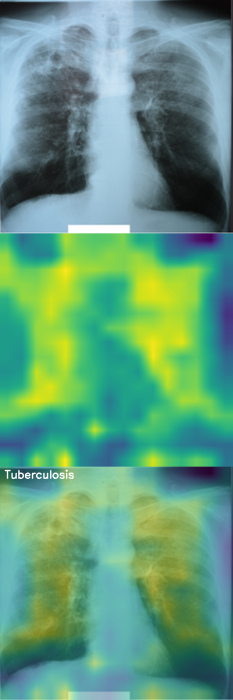

In [ ]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import imutils

class GradCAM:
  def __init__(self, model, classIdx, layerName=None):
    self.model = model
    self.classIdx = classIdx
    self.layerName = layerName
    if self.layerName is None:
      self.layerName = self.find_target_layer()
   
  def find_target_layer(self):
    for layer in reversed(self.model.layers):
      if len(layer.output_shape) == 4:
        return layer.name
    raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

  def compute_heatmap(self, image, eps=1e-8):
    gradModel = Model(
			inputs=[self.model.inputs],
			outputs=[self.model.get_layer(self.layerName).output,
				self.model.output])
    with tf.GradientTape() as tape:
      inputs = tf.cast(image, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, self.classIdx]
    grads = tape.gradient(loss, convOutputs)
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
    (w, h) = (image.shape[2], image.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")
    return heatmap

  def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_VIRIDIS):
    heatmap = cv2.applyColorMap(heatmap, colormap)
    output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    return (heatmap, output)

path = "Dataset/Tuberculosis/Tuberculosis-310.png"
orig = cv2.imread(path)
resized = cv2.resize(orig, (256, 256))

image = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
image = tf.keras.preprocessing.image.img_to_array(image)
image = np.expand_dims(image, axis=0)

predictions = model.predict(image)
cam = GradCAM(model, np.argmax(predictions[0]), "expanded_conv_6/expand")
heatmap = cv2.resize(cam.compute_heatmap(image), (orig.shape[1], orig.shape[0]))

#heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

#cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
cv2.putText(output, classes[np.argmax(predictions)], (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

output = np.vstack([orig, heatmap, output])
output = imutils.resize(output, height=700)
cv2_imshow(output)